# Intro

## Overview

This project aim to predict whether a credit card transaction is fradulent or not in real time. This uses a streaming dataflow pipeline to

* consume incoming transaction details from Cloud Pub/Sub
* does data preprocessing (by calling Firestore for data enrichment using transaction history)
* invokes multiple ML models deployed on AI Platform
* stores the prediction results to BigQuery and
* sends notification to another Pub/Sub topic when a transaction is predicted fraudlent for downstream consumptions

Refer the below architecture diagram



```
# This is formatted as code
```

## Architecture

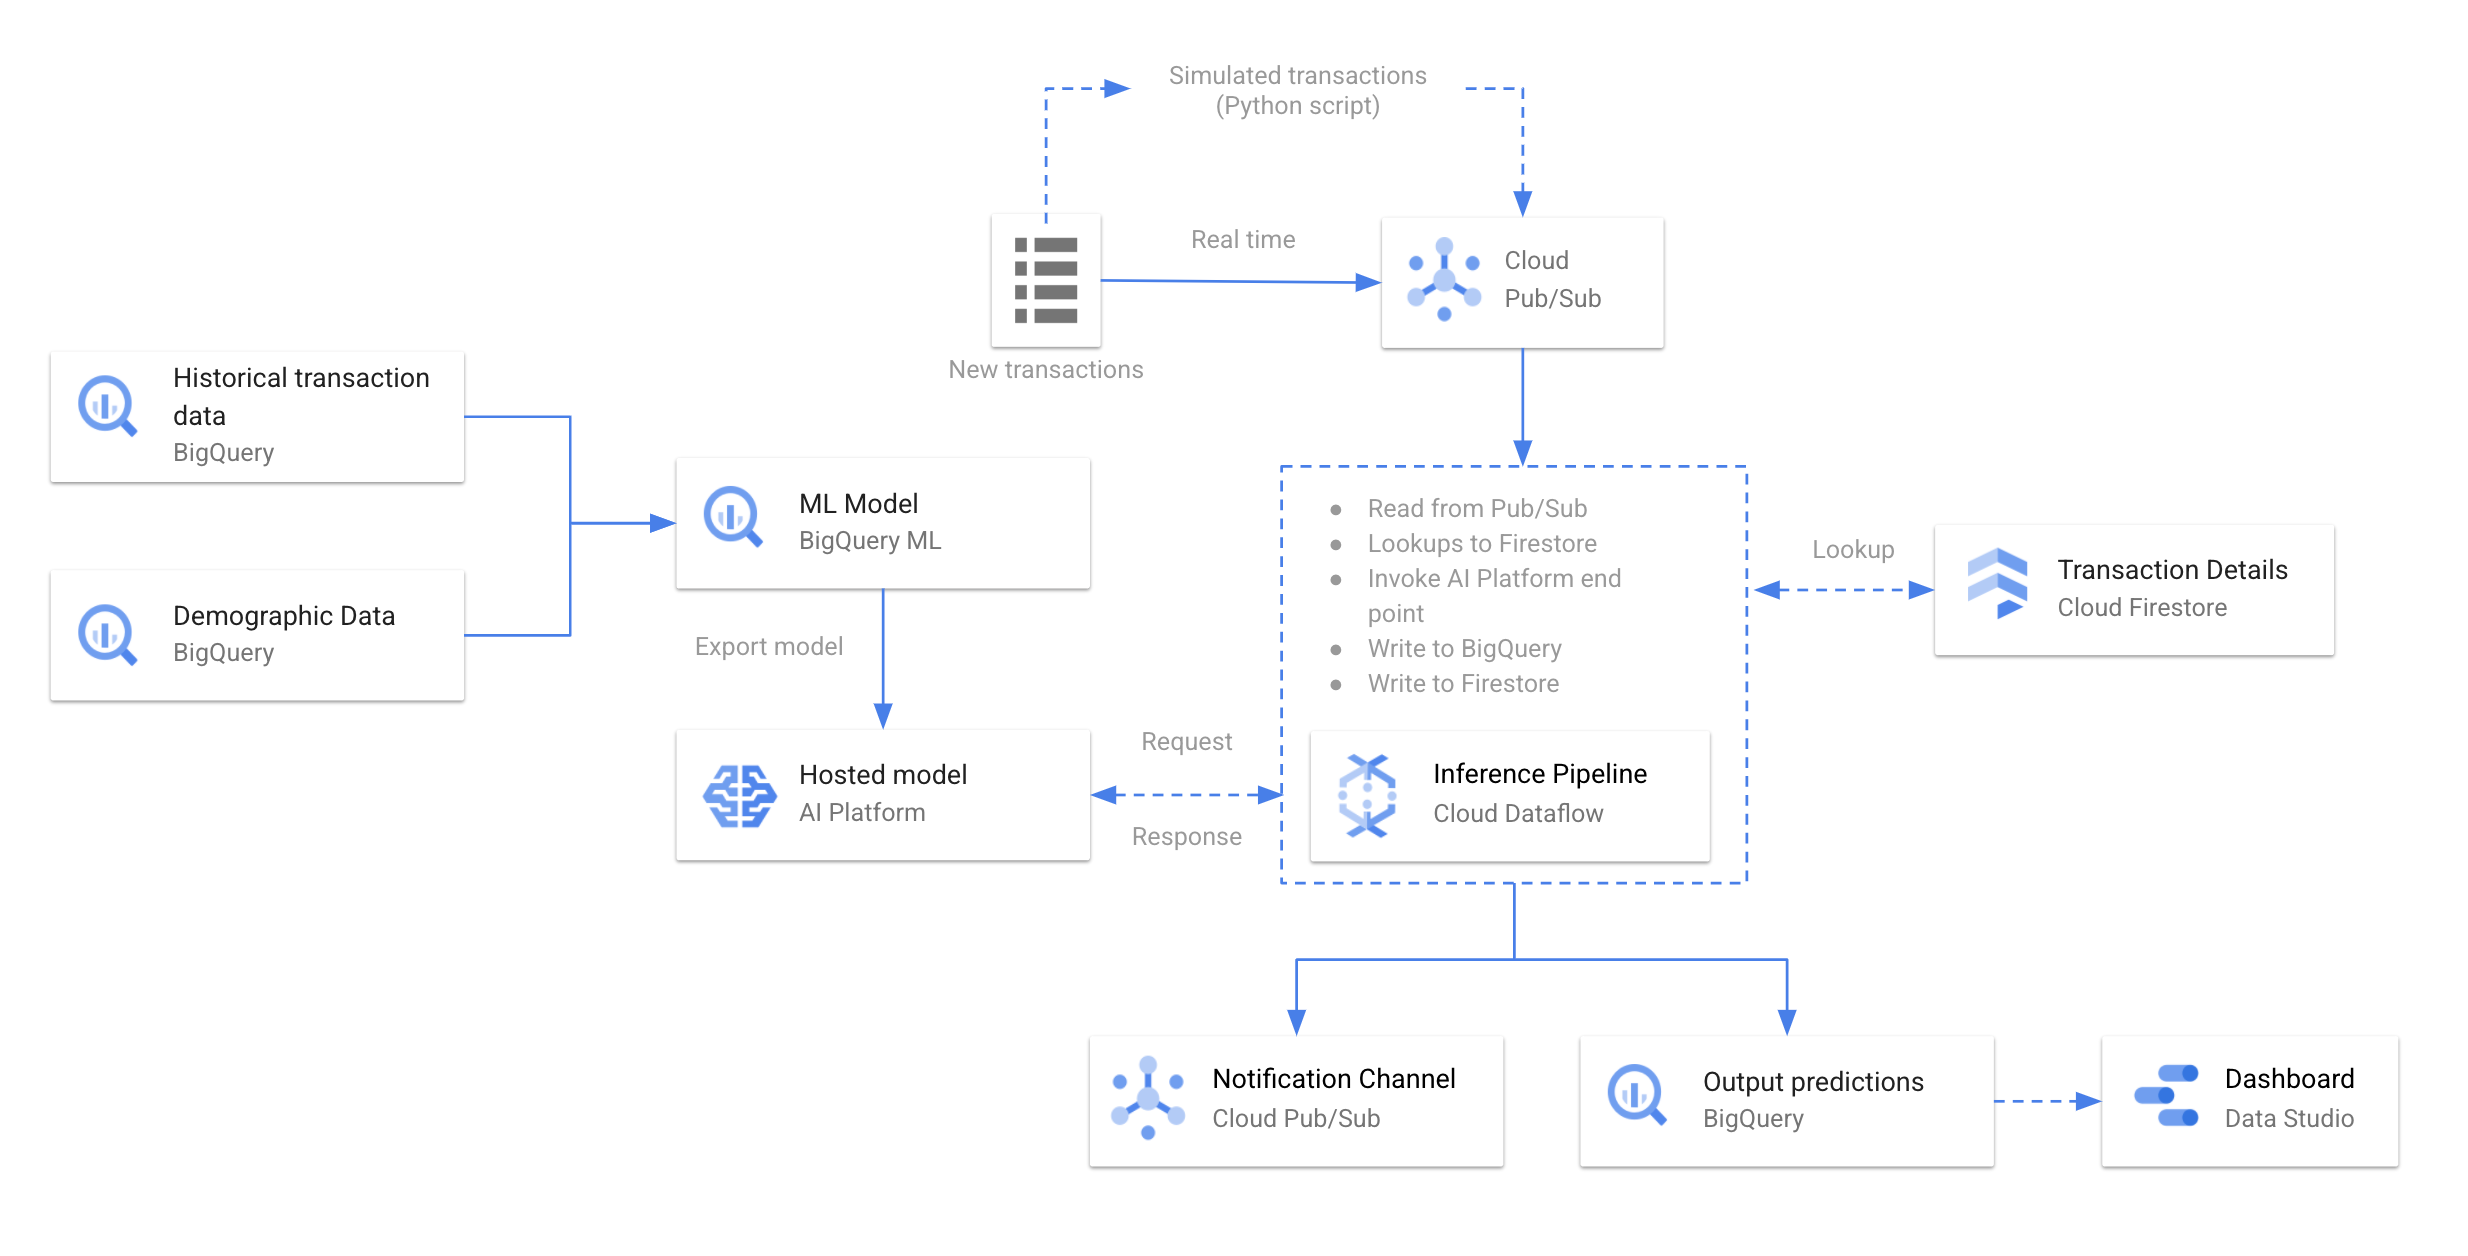

## Dataset

Below are the details of BigQuery tables & models used for this pattern which are publicly available (The underlying source dataset is from Kaggle)
* Project ID: qp-fraud-detection
* Dataset name: cc_datacc_data
* Tables:

  * train_raw - Data used for ML model training
  * test_raw - Data used for ML model evaluation
  * simulation_data - Data to be used for realtime inferences
  * train_with_standard - BQ view providing features for training simple model
  * train_with_aggregates - BQ view providing features for training model with aggregates
  * test_with_standard - BQ view providing test data for evaluating simple model
  * test_with_aggregates - BQ view providing test data for evaluating model with aggregates
  * demographics - Data comprising customer demographics like name, gender, address

## Model

For this pattern, we opted for XGBoost model which worked really well while still retaining some level of model explainability. We initially used the boosted tree classifier in BigQuery ML by using standard SQL to train the model and arrive at the probability score for each transaction. Due to the imbalanced nature of the dataset, we used F1 score and AUC to evaluate the performance of the model. 

After the initial evaluation, to boost the performance of the model we derived additional features from the dataset focusing on the frequency of the transactions and the average transaction amount over a period of time. 

As part of the solution, we have used predictions from both the models as part of the pipeline. The model using the standard features gives you relatively faster results, the other model uses the features derived from looking at historical data to make the predictions.

## Model Differences

In this example, we have two types of models


* Model with standard features: This uses the features which are present in the dataset and doesn't rely on any feature generation techniques


* Model with aggregate fetures: Along with the provided features, this uses feature generation techniques to compute transaction frequency, average spend etc for a given credit card
  * trans_freq_24 - Number of transactions in the last 24 hours
  * trans_diff - Time difference between current transaction and last transaction in seconds
  * avg_spend_pw - Average transaction amount in the past 1 week
  * avg_spend_pm - Average transaction amount in the past 1 month

| Feature       | Derived     | Used in Model1 | Used in Model2,3,4 |
| ------------- |-------------| --------------:| --------------:|
| category      | No          | Yes            | Yes            |
| amt           | No          | Yes            | Yes            |
| gender        | No          | No             | No             |
| state         | No          | Yes            | Yes            |
| job           | No          | Yes            | Yes            |
| unix_time     | No          | Yes            | Yes            |
| city_pop      | No          | Yes            | Yes            |
| merchant      | No          | Yes            | Yes            |
| day           | Yes         | Yes            | Yes            |
| age           | Yes         | Yes            | Yes            |
| distance      | Yes         | Yes            | Yes            |
| trans_freq_24 | Yes         | No             | Yes            |
| trans_diff    | Yes         | No             | Yes            |
| avg_spend_pw  | Yes         | No             | Yes            |
| avg_spend_pm  | Yes         | No             | Yes            |

#Environment Setup

In [ ]:
# Automatically restart kernel after installs
!pip install --upgrade google-cloud-pubsub
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True) 

     |████████████████████████████████| 233 kB 4.3 MB/s 
     |████████████████████████████████| 46 kB 2.6 MB/s 
     |████████████████████████████████| 4.4 MB 44.1 MB/s 
     |████████████████████████████████| 1.0 MB 36.6 MB/s 
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.17.3
    Uninstalling protobuf-3.17.3:
      Successfully uninstalled protobuf-3.17.3
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.44.0
    Uninstalling grpcio-1.44.0:
      Successfully uninstalled grpcio-1.44.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.


{'restart': True, 'status': 'ok'}

In [ ]:
from google.cloud import bigquery
import pandas as pd

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/content/gdrive/My Drive/CMPE 255/Project/cmpe-255-342823.json"
os.environ["PROJECT_ID"]="cmpe-255-342823"
os.environ["DATASET"]="BQML_CREDIT_CARD_FRAUD"
os.environ["REGION"]="US"
os.environ["OUTPUT_BQ_TABLE"]="REAL_TIME_TRANSACTIONS"
os.environ["MODEL_NAME_WITH_STANDARD"]="MODEL_1_BTC_WITH_STANDARD"
os.environ["MODEL_NAME_WITH_AGGREGATES"]="MODEL_2_BTC_WITH_AGGREGATES"
os.environ["BUCKET_NAME"]="cmpe-255-342823"
os.environ["AI_MODEL_NAME"]="AI_MODEL_1"
os.environ["VERSION_NAME_WITH_STANDARD"]="VERSION_1_WITH_STANDARD"
os.environ["VERSION_NAME_WITH_AGGREGATES"]="VERSION_2_WITH_AGGREGATES"
os.environ["FIRESTORE_COLLECTION_NAME"]="CREDIT_CARD_FRAUD"
os.environ["PUBSUB_TOPIC_NAME"]="TOPIC-CREDIT-CARD-FRAUD"
os.environ["PUBSUB_SUBSCRIPTION_NAME"]="SUBSCRIPTION-CREDIT-CARD-FRAUD"
os.environ["PUBSUB_NOTIFICATION_TOPIC"]="NOTIFICATION-CREDIT-CARD-FRAUD"
os.environ["PUBSUB_NOTIFICATION_SUBSCRIPTION"]="ALARM-CREDIT-CARD-FRAUD"
os.environ["DASHBOARD_NAME"]="CREDIT_CARD_FRAUD"

In [ ]:
!export -p

declare -x AI_MODEL_NAME="AI_MODEL_1"
declare -x BUCKET_NAME="cmpe-255-342823"
declare -x CLICOLOR="1"
declare -x CLOUDSDK_CONFIG="/content/.config"
declare -x CLOUDSDK_PYTHON="python3"
declare -x COLAB_GPU="0"
declare -x CUDA_VERSION="11.1.1"
declare -x CUDNN_VERSION="8.0.5.39"
declare -x DASHBOARD_NAME="CREDIT_CARD_FRAUD"
declare -x DATALAB_SETTINGS_OVERRIDES="{\"kernelManagerProxyPort\":6000,\"kernelManagerProxyHost\":\"172.28.0.3\",\"jupyterArgs\":[\"--ip=\\\"172.28.0.2\\\"\"],\"debugAdapterMultiplexerPath\":\"/usr/local/bin/dap_multiplexer\",\"enableLsp\":true}"
declare -x DATASET="BQML_CREDIT_CARD_FRAUD"
declare -x DEBIAN_FRONTEND="noninteractive"
declare -x ENABLE_DIRECTORYPREFETCHER="1"
declare -x ENV="/root/.bashrc"
declare -x FIRESTORE_COLLECTION_NAME="CREDIT_CARD_FRAUD"
declare -x GCE_METADATA_TIMEOUT="3"
declare -x GCS_READ_CACHE_BLOCK_SIZE_MB="16"
declare -x GIT_PAGER="cat"
declare -x GLIBCPP_FORCE_NEW="1"
declare -x GLIBCXX_FORCE_NEW="1"
declare -x GOOGLE_APPLICATION_CRED

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!gcloud auth login

You are authorizing gcloud CLI without access to a web browser. Please run the following command on a machine with a web browser and copy its output back here. Make sure the installed gcloud version is 372.0.0 or newer.

gcloud auth login --remote-bootstrap="https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=alSZC4reUskYjmjCC9Py3ZQ6Fk34Vt&access_type=offline&code_challenge=2GqP-L4_iUvv7ilQnU2r2q6hPmCrsPd-wQ9AeUj-cZw&code_challenge_method=S256&token_usage=remote"


Enter the output of the above command: https://localhost:8085/?state=alSZC4reUskYjmjCC9Py3ZQ6Fk34Vt&code=4/0AX4XfWhJX5hGo7XfzxUQ_7q_fOzI6v9Q6uag3LWg0_L014G7LAR6DpcW6HjjDKsaO

In [ ]:
!gcloud config set project $PROJECT_ID

Updated property [core/project].


In [ ]:
def implicit():
    from google.cloud import storage

    # If you don't specify credentials when constructing the client, the
    # client library will look for credentials in the environment.
    storage_client = storage.Client()

    # Make an authenticated API request
    buckets = list(storage_client.list_buckets())
    print(buckets)

implicit()

[<Bucket: cmpe-255-342823>, <Bucket: cmpe-255-342823.appspot.com>, <Bucket: staging.cmpe-255-342823.appspot.com>]


In [ ]:
#!gsutil mb gs://$BUCKET_NAME
#!bq --location=US mk --dataset $PROJECT_ID:$DATASET
#!bq mk --table $DATASET.$OUTPUT_BQ_TABLE '/content/gdrive/My Drive/CMPE 255/Project/utilities/output_schema.json'

!gcloud alpha storage ls
!gcloud alpha bq tables list --dataset $DATASET

gs://cmpe-255-342823/
gs://cmpe-255-342823.appspot.com/
gs://staging.cmpe-255-342823.appspot.com/
DATASET_ID              TABLE_ID                          CREATION_TIME        EXPIRATION_TIME  TYPE
BQML_CREDIT_CARD_FRAUD  MODEL_1_CONFUSION_MATRIX          2022-04-19T03:15:56                   VIEW
BQML_CREDIT_CARD_FRAUD  MODEL_1_EVALUATION                2022-04-19T03:45:10                   VIEW
BQML_CREDIT_CARD_FRAUD  MODEL_1_PREDICATION_CONTRIBUTION  2022-04-19T03:47:25                   VIEW
BQML_CREDIT_CARD_FRAUD  MODEL_2_CONFUSION_MATRIX          2022-04-19T04:00:43                   VIEW
BQML_CREDIT_CARD_FRAUD  MODEL_2_EVALUATION                2022-04-19T04:00:31                   VIEW
BQML_CREDIT_CARD_FRAUD  MODEL_2_PREDICATION_CONTRIBUTION  2022-04-19T04:01:33                   VIEW
BQML_CREDIT_CARD_FRAUD  MODEL_3_CONFUSION_MATRIX          2022-05-11T11:34:36                   VIEW
BQML_CREDIT_CARD_FRAUD  MODEL_3_EVALUATION                2022-05-11T11:33:09                 

In [ ]:
PROJECT_ID = os.environ['PROJECT_ID']
DATASET = os.environ['DATASET']

#Data Preparation (GCP BigQuery)

## Data Acquisition

In [ ]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW BQML_CREDIT_CARD_FRAUD.train_raw AS (

SELECT 
  *
FROM
  qp-fraud-detection.cc_data.train_raw
);

""


In [ ]:
%%bigquery --project $PROJECT_ID

SELECT
  *
FROM
  BQML_CREDIT_CARD_FRAUD.train_raw
LIMIT
  10

,trans_date_trans_time,cc_num,merchant,category,amt,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2020-04-21 22:58:03+00:00,213161231269724,fraud_O'Connell-Ullrich,home,57.990,46daa9f2222218deca6e2c2109343d11,1587509883,34.204,-86.917,0
1,2020-01-03 19:27:50+00:00,676102124465,fraud_Schmidt-Larkin,home,84.680,82e570eb97ebaa092499092fe5ea1fab,1578079670,38.101,-122.377,0
2,2019-05-28 23:29:56+00:00,630484879808,fraud_Lynch-Wisozk,home,79.990,8c35f87341d3fe32b24cb8295e85e0b4,1559086196,35.524,-120.682,0
3,2019-07-07 22:19:30+00:00,3521815216091574,fraud_Botsford and Sons,home,80.500,5deaa865f67cf305ec5551094ebde410,1562537970,38.790,-105.534,0
4,2019-07-13 20:01:11+00:00,213148039875802,fraud_Lynch-Wisozk,home,71.180,7056c8f7ce3386a47460450f5796e01f,1563048071,28.876,-82.427,0
5,2019-08-11 12:46:58+00:00,3591919803438423,"fraud_Koss, Hansen and Lueilwitz",home,41.710,dc1e9b5393c6cbd09e2707b85ae0f3a1,1565527618,29.364,-80.987,0
6,2020-02-28 17:34:00+00:00,3591919803438423,fraud_Botsford and Sons,home,36.950,c8a7c1e0c51a3ae890b2d9a160b9aa64,1582911240,29.389,-81.572,0
7,2019-11-18 17:25:43+00:00,4935858973307492,"fraud_Schiller, Blanda and Johnson",home,81.090,249b4c6dae3d8c05b1be58c9d19bdf2f,1574097943,33.617,-83.861,0
8,2019-10-26 12:04:26+00:00,371226440126102,"fraud_Cole, Hills and Jewess",home,41.170,3a1026ba767282e8e065730ebff9044c,1572091466,38.077,-90.122,0
9,2019-07-29 23:16:46+00:00,3517527805128735,fraud_White and Sons,home,22.620,ffedd4a982be3bdb9714895aa77dad43,1564442206,41.856,-88.337,0


In [ ]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW BQML_CREDIT_CARD_FRAUD.test_raw AS (

SELECT 
  *
FROM
  qp-fraud-detection.cc_data.test_raw
);

""


In [ ]:
%%bigquery --project $PROJECT_ID

SELECT
  *
FROM
  BQML_CREDIT_CARD_FRAUD.test_raw
LIMIT
  10

,trans_date_trans_time,cc_num,merchant,category,amt,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2020-11-08 12:45:30+00:00,3560725013359375,fraud_Terry Ltd,home,2.140,ea3c5ac908868e31e2af21100ca03c7d,1604839530,31.969,-103.465,0
1,2020-10-20 15:57:21+00:00,6011552879910390,fraud_Terry Ltd,home,74.010,729102566be5d0cfc1178c9896cb341a,1603209441,41.168,-110.509,0
2,2020-07-29 18:07:24+00:00,342952484382519,fraud_Terry Ltd,home,7.050,a88f877833ac69d015a2b0c9abbc974e,1596046044,42.151,-73.330,0
3,2020-10-14 23:47:04+00:00,4355790796238264643,fraud_Terry Ltd,home,2.920,a889661648cc5c4313db7e3c6166667a,1602719224,38.995,-92.109,0
4,2020-09-15 22:37:54+00:00,213124978348176,fraud_Terry Ltd,home,18.660,a5630fa54b879c1bc91ad5e38ee232ba,1600209474,41.726,-78.507,0
5,2020-06-26 16:43:19+00:00,180064817343047,fraud_Terry Ltd,home,84.960,5583d5dcfe0536f5a4fc0cbcf8395b06,1593189799,38.733,-86.963,0
6,2020-06-21 15:38:16+00:00,30143713661454,fraud_Terry Ltd,home,43.080,4be7bae3487b73ef9d1ecede7d310b40,1592753896,49.579,-97.163,0
7,2020-11-08 17:19:14+00:00,5410056176712193,fraud_Terry Ltd,home,117.200,26de7672ca2bbc87f1c25e5253496b3a,1604855954,45.531,-88.800,0
8,2020-07-14 21:26:14+00:00,4512828414983801773,fraud_Terry Ltd,home,9.790,0aa1c637e0586fa4bedf4e4aec819e73,1594761974,39.811,-78.898,0
9,2020-11-28 12:07:40+00:00,675990301623,fraud_Terry Ltd,home,165.320,24f09bb21a57099064af33475d1f6ce1,1606565260,41.476,-74.654,0


In [ ]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW BQML_CREDIT_CARD_FRAUD.demographics AS (

SELECT 
  *
FROM
  qp-fraud-detection.cc_data.demographics
);

""


In [ ]:
%%bigquery --project $PROJECT_ID

SELECT
  *
FROM
  BQML_CREDIT_CARD_FRAUD.demographics
LIMIT
  10

,cc_num,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob
0,573283817795,Amy,Flynn,F,46095 Tara Fords,Jaffrey,NH,3452,42.818,-72.028,5457,"Surveyor, hydrographic",1950-04-17
1,4044436772018844508,Amy,Abbott,F,01505 Amy Stravenue,Dayton,OH,45415,39.836,-84.261,479994,Environmental manager,1970-11-09
2,2222157926772399,Amy,Garrett,F,6014 Thomas Throughway,Trenton,TX,75490,33.423,-96.340,2211,"Investment banker, operational",1987-02-26
3,4335531783520911,Amy,Daugherty,F,852 Thomas Well Suite 339,Owensville,MO,65066,38.351,-91.487,6703,Naval architect,1998-05-20
4,36913587729122,Ana,Mccormick,F,4503 Patricia Route,Meridian,ID,83646,43.650,-116.431,84106,Intelligence analyst,1971-02-11
5,213112402583773,Ana,Howell,F,4664 Sanchez Common Suite 930,Bradley,SC,29819,34.033,-82.203,1523,Research scientist (physical sciences),1984-06-03
6,6011724471098086,Ann,Lawson,F,144 Evans Islands Apt. 683,Burbank,WA,99323,46.197,-118.902,3684,Musician,1981-11-29
7,38052002992326,Anna,Logan,F,3522 Park Wells Suite 528,Cleveland,TX,77327,30.330,-95.020,34153,Building surveyor,1995-09-11
8,3583793405872580,Beth,Lambert,F,6447 Johnson Estates Apt. 986,Roosevelt,OK,73564,34.847,-98.984,551,Amenity horticulturist,1970-09-27
9,3576021480694169,Dawn,Gray,F,9486 Joel Common Suite 554,Topeka,KS,66618,39.133,-95.702,163415,Secondary school teacher,2004-12-30


In [ ]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW BQML_CREDIT_CARD_FRAUD.simulation_data AS (

SELECT 
  *
FROM
  qp-fraud-detection.cc_data.simulation_data
);

""


In [ ]:
%%bigquery --project $PROJECT_ID

SELECT
  *
FROM
  BQML_CREDIT_CARD_FRAUD.simulation_data
LIMIT
  10

,trans_date_trans_time,cc_num,merchant,category,amt,trans_num,unix_time,merch_lat,merch_long
0,2020-12-28 23:38:22+00:00,4464457352619,fraud_Terry Ltd,home,66.590,4bb3d95e101889ff6a26d5de2b373576,1609198702,29.165,-85.162
1,2020-12-25 17:18:48+00:00,4092452671396169678,fraud_Terry Ltd,home,138.080,33b4828af201c47ed0606e68d88e2bc1,1608916728,33.635,-78.338
2,2020-12-22 19:53:56+00:00,4503101193493052864,fraud_Terry Ltd,home,22.630,6b28cb28d3c38c74f6f2947099a34f9b,1608666836,27.976,-83.001
3,2020-12-21 16:41:42+00:00,30042378430132,fraud_Terry Ltd,home,129.070,f27223810dd4bda38ea35247bd85cd12,1608568902,40.739,-72.887
4,2020-12-23 12:25:49+00:00,4873783502705038,fraud_Terry Ltd,home,32.840,7aefacbfc66a2b85fb8d74c66352405d,1608726349,47.630,-123.135
5,2020-12-24 12:29:16+00:00,3595192916105588,fraud_Terry Ltd,home,70.740,eea6436a308fd294d2e0e6b0b8420f41,1608812956,35.399,-79.899
6,2020-12-24 13:33:49+00:00,4500002361389,fraud_Terry Ltd,home,14.230,7ad00e143d0499da8f59c56f2436277e,1608816829,38.254,-75.335
7,2020-12-28 16:06:44+00:00,180036456789979,fraud_Terry Ltd,home,109.590,2d864100ace0e2e13ce4fd4a326e48f3,1609171604,42.781,-91.832
8,2020-12-28 16:38:29+00:00,4561546772499,fraud_Terry Ltd,home,37.470,96c11125f9d4615fc149654c53563031,1609173509,35.534,-106.856
9,2020-12-28 16:29:22+00:00,3540075240003197,fraud_Terry Ltd,home,125.340,41c3ec99ab52d6127bd722f3a7fecfff,1609172962,43.688,-93.068


In [ ]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW BQML_CREDIT_CARD_FRAUD.fraud_data AS (

SELECT
    trans_num, trans_date_trans_time, is_fraud_model_w_aggregates, prob_is_fraud_model_w_aggregates
FROM
    `qp-fraud-detection.cc_data.transactions_data`
WHERE
    is_fraud_model_w_aggregates = 1
ORDER BY
    trans_date_trans_time DESC
);

""


In [ ]:
%%bigquery --project $PROJECT_ID

SELECT
  *
FROM
  BQML_CREDIT_CARD_FRAUD.fraud_data

,trans_num,trans_date_trans_time,is_fraud_model_w_aggregates,prob_is_fraud_model_w_aggregates
0,ba5aeadb540df85b19789819e0fa31e3,2020-12-30 04:00:50+00:00,1,"[0.66349, 0.33651]"
1,e8ba8d9e41ad65a00576086393f5b783,2020-12-29 22:44:49+00:00,1,"[0.64019, 0.35981]"
2,c88b7addfc9f508f875efa3758f7d5e9,2020-12-29 18:00:46+00:00,1,"[0.76706, 0.23294]"
3,3eeda99c624b08cdc457dd3ceb07ef1e,2020-12-29 01:35:42+00:00,1,"[0.80165, 0.19835]"
4,8648a3f2c34cf19ee20b4073be15ffb4,2020-12-23 08:42:34+00:00,1,"[0.9967, 0.0033]"
5,44292cbc51e37dc018ee6a988a4bc426,2020-12-22 23:13:39+00:00,1,"[0.99758, 0.00242]"
6,2df7d894868fbc99ec1d8b055585fc9d,2020-12-22 23:06:03+00:00,1,"[0.98319, 0.01681]"
7,25b076c7bcd70f272c1c5326bb234f4b,2020-12-22 22:31:48+00:00,1,"[0.99714, 0.00286]"
8,da7f67d7375f10a054a3d919448c45dd,2020-12-22 22:18:07+00:00,1,"[0.99546, 0.00454]"
9,35b0297dd026d2e9a75d024a5dec7955,2020-12-22 22:05:48+00:00,1,"[0.97398, 0.02602]"


## Data Analysis and Preprosessing

In [ ]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW BQML_CREDIT_CARD_FRAUD.train_with_standard AS (

SELECT 
      EXTRACT 
      (dayofweek FROM trans_date_trans_time) AS day,
      DATE_DIFF(EXTRACT(DATE FROM trans_date_trans_time),dob, YEAR) AS age,
      ST_DISTANCE(ST_GEOGPOINT(long,lat), ST_GEOGPOINT(merch_long, merch_lat)) AS distance,
      category,
      amt,
      state,
      job,
      unix_time,
      city_pop,
      merchant,
      is_fraud
  FROM (
    SELECT 
      * EXCEPT(cc_num)
    FROM 
      BQML_CREDIT_CARD_FRAUD.train_raw t1
    LEFT JOIN 
      BQML_CREDIT_CARD_FRAUD.demographics t2 ON t1.cc_num =t2.cc_num))

""


In [ ]:
%%bigquery --project $PROJECT_ID

SELECT
  *
FROM
  BQML_CREDIT_CARD_FRAUD.train_with_standard
LIMIT
  10

,day,age,distance,category,amt,state,job,unix_time,city_pop,merchant,is_fraud
0,3,57,92963.930,home,57.990,AL,Physiological scientist,1587509883,67082,fraud_O'Connell-Ullrich,0
1,6,35,40759.494,home,84.680,CA,Airline pilot,1578079670,94014,fraud_Schmidt-Larkin,0
2,3,46,120668.764,home,79.990,CA,Early years teacher,1559086196,123,fraud_Lynch-Wisozk,0
3,1,41,107484.736,home,80.500,CO,Mental health nurse,1562537970,565,fraud_Botsford and Sons,0
4,7,41,103163.420,home,71.180,FL,Environmental consultant,1563048071,79613,fraud_Lynch-Wisozk,0
5,1,32,89832.697,home,41.710,FL,Set designer,1565527618,54767,"fraud_Koss, Hansen and Lueilwitz",0
6,6,33,116899.444,home,36.950,FL,Set designer,1582911240,54767,fraud_Botsford and Sons,0
7,2,44,110292.499,home,81.090,GA,Film/video editor,1574097943,1841,"fraud_Schiller, Blanda and Johnson",0
8,7,45,121797.899,home,41.170,IL,Race relations officer,1572091466,1810,"fraud_Cole, Hills and Jewess",0
9,2,29,80966.500,home,22.620,IL,Medical secretary,1564442206,1617,fraud_White and Sons,0


In [ ]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW BQML_CREDIT_CARD_FRAUD.train_with_aggregates AS (

SELECT  
    EXTRACT 
    (dayofweek FROM trans_date_trans_time) AS day,
    DATE_DIFF(EXTRACT(DATE FROM trans_date_trans_time),dob, YEAR) AS age,
    ST_DISTANCE(ST_GEOGPOINT(long,lat), ST_GEOGPOINT(merch_long, merch_lat)) AS distance,
    TIMESTAMP_DIFF(trans_date_trans_time, last_txn_date , MINUTE) AS trans_diff, 
    AVG(amt) OVER(
                PARTITION BY cc_num
                ORDER BY unix_time
                -- 1 week is 604800 seconds
                RANGE BETWEEN 604800 PRECEDING AND 1 PRECEDING) AS avg_spend_pw,
    AVG(amt) OVER(
                PARTITION BY cc_num
                ORDER BY unix_time
                -- 1 month(30 days) is 2592000 seconds (technically)
                RANGE BETWEEN 2592000 PRECEDING AND 1 PRECEDING) AS avg_spend_pm,
    COUNT(*) OVER(
                PARTITION BY cc_num
                ORDER BY unix_time
                -- 1 day is 86400 seconds
                RANGE BETWEEN 86400 PRECEDING AND 1 PRECEDING ) AS trans_freq_24,
    category,
    amt,
    state,
    job,
    unix_time,
    city_pop,
    merchant,
    is_fraud
  FROM (
          SELECT 
            t1.*,t2.* EXCEPT(cc_num),
            LAG(trans_date_trans_time) OVER 
            (PARTITION BY t1.cc_num ORDER BY trans_date_trans_time ASC) AS last_txn_date,
          FROM  
            BQML_CREDIT_CARD_FRAUD.train_raw t1
          LEFT JOIN  
            BQML_CREDIT_CARD_FRAUD.demographics t2 ON t1.cc_num =t2.cc_num))


""


In [ ]:
%%bigquery --project $PROJECT_ID

SELECT
  *
FROM
  BQML_CREDIT_CARD_FRAUD.train_with_aggregates
LIMIT
  10

,day,age,distance,trans_diff,avg_spend_pw,avg_spend_pm,trans_freq_24,category,amt,state,job,unix_time,city_pop,merchant,is_fraud
0,3,27,101096.976,NaN,NaN,NaN,0,grocery_net,90.240,IL,"Teacher, secondary school",1546312016,128354,fraud_Trantow PLC,0
1,3,27,82432.037,121.000,90.240,90.240,1,misc_pos,26.860,IL,"Teacher, secondary school",1546319319,128354,fraud_Stamm-Rodriguez,0
2,3,27,32324.792,963.000,58.550,58.550,2,shopping_net,170.260,IL,"Teacher, secondary school",1546377127,128354,"fraud_Heathcote, Yost and Kertzmann",0
3,4,27,97494.815,217.000,95.787,95.787,3,misc_net,249.570,IL,"Teacher, secondary school",1546390162,128354,fraud_Kunde-Sanford,0
4,4,27,102557.280,447.000,134.232,134.232,2,grocery_pos,236.370,IL,"Teacher, secondary school",1546417001,128354,fraud_Goodwin-Nitzsche,0
5,4,27,70456.758,137.000,154.660,154.660,3,grocery_pos,232.950,IL,"Teacher, secondary school",1546425234,128354,fraud_Strosin-Cruickshank,0
6,5,27,49732.995,1440.000,167.708,167.708,0,grocery_pos,166.030,IL,"Teacher, secondary school",1546511687,128354,"fraud_Rowe, Batz and Goodwin",0
7,6,27,92614.247,1824.000,167.469,167.469,0,entertainment,69.930,IL,"Teacher, secondary school",1546621179,128354,fraud_Abshire PLC,0
8,7,27,36763.149,1415.000,155.276,155.276,1,shopping_pos,167.220,IL,"Teacher, secondary school",1546706128,128354,fraud_Hermann and Sons,0
9,7,27,95445.397,48.000,156.603,156.603,1,entertainment,69.200,IL,"Teacher, secondary school",1546709020,128354,"fraud_Larkin, Stracke and Greenfelder",0


In [ ]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW BQML_CREDIT_CARD_FRAUD.test_with_standard AS (

SELECT 
      EXTRACT (dayofweek FROM trans_date_trans_time) AS day,
      DATE_DIFF(EXTRACT(DATE FROM trans_date_trans_time),dob, YEAR) AS age,
      ST_DISTANCE(ST_GEOGPOINT(long,lat), ST_GEOGPOINT(merch_long, merch_lat)) AS distance,
      category,
      amt,
      state,
      job,
      unix_time,
      city_pop,
      merchant,
      is_fraud
  FROM (
    SELECT 
      * EXCEPT(cc_num)
    FROM 
      BQML_CREDIT_CARD_FRAUD.test_raw t1
    LEFT JOIN 
      BQML_CREDIT_CARD_FRAUD.demographics t2 ON t1.cc_num =t2.cc_num))


""


In [ ]:
%%bigquery --project $PROJECT_ID

SELECT
  *
FROM
  BQML_CREDIT_CARD_FRAUD.test_with_standard
LIMIT
  10

,day,age,distance,category,amt,state,job,unix_time,city_pop,merchant,is_fraud
0,1,51,69366.061,home,2.140,TX,Cytogeneticist,1604839530,23,fraud_Terry Ltd,0
1,3,39,31794.159,home,74.010,WY,Research scientist (physical sciences),1603209441,49,fraud_Terry Ltd,0
2,4,33,15347.228,home,7.050,CT,Comptroller,1596046044,647,fraud_Terry Ltd,0
3,4,51,116635.900,home,2.920,IL,Exhibition designer,1602719224,1656,fraud_Terry Ltd,0
4,3,58,74306.982,home,18.660,NY,Mechanical engineer,1600209474,1766,fraud_Terry Ltd,0
5,6,53,99694.682,home,84.960,KY,Chartered public finance accountant,1593189799,344,fraud_Terry Ltd,0
6,1,78,109507.556,home,43.080,MN,"Embryologist, clinical",1592753896,140,fraud_Terry Ltd,0
7,1,31,132478.754,home,117.200,WI,Art therapist,1604855954,4306,fraud_Terry Ltd,0
8,3,37,76342.695,home,9.790,PA,Tree surgeon,1594761974,328,fraud_Terry Ltd,0
9,7,26,44675.063,home,165.320,NJ,Senior tax professional/tax inspector,1606565260,2456,fraud_Terry Ltd,0


In [ ]:
%%bigquery --project $PROJECT_ID

CREATE VIEW `BQML_CREDIT_CARD_FRAUD.test_with_aggregates` AS (

WITH t1 as (
SELECT *, 'train' AS split FROM  `BQML_CREDIT_CARD_FRAUD.train_raw` 
UNION ALL 
SELECT *, 'test' AS split FROM  `BQML_CREDIT_CARD_FRAUD.test_raw`
),
v2 AS (
  SELECT t1.*,t2.* EXCEPT(cc_num),
              LAG(trans_date_trans_time) OVER (PARTITION BY t1.cc_num ORDER BY trans_date_trans_time ASC) AS last_txn_date,
            FROM t1
            LEFT JOIN  `BQML_CREDIT_CARD_FRAUD.demographics` t2 ON t1.cc_num = t2.cc_num
),
v3 AS (
  SELECT
        EXTRACT (dayofweek FROM trans_date_trans_time) as day,
        DATE_DIFF(EXTRACT(DATE FROM trans_date_trans_time),dob, YEAR) AS age,
        ST_DISTANCE(ST_GEOGPOINT(long,lat), ST_GEOGPOINT(merch_long, merch_lat)) as distance,
        TIMESTAMP_DIFF(trans_date_trans_time, last_txn_date , MINUTE) AS trans_diff, 
        Avg(amt) OVER(
                    PARTITION BY cc_num
                    ORDER BY unix_time
                    RANGE BETWEEN 604800 PRECEDING AND 1 PRECEDING) AS avg_spend_pw,
        Avg(amt) OVER(
                    PARTITION BY cc_num
                    ORDER BY unix_time
                    RANGE BETWEEN 2592000 PRECEDING AND 1 PRECEDING) AS avg_spend_pm,
        count(*) OVER(
                    PARTITION BY cc_num
                    ORDER BY unix_time
                    RANGE BETWEEN 86400 PRECEDING AND 1 PRECEDING) AS trans_freq_24,
        category,
        amt,
        state,
        job,
        unix_time,
        city_pop,
        merchant,
        is_fraud,
        split
    FROM v2
)
SELECT 
  * EXCEPT(split) 
FROM 
  v3
WHERE 
  split='test'
  )


""


In [ ]:
%%bigquery --project $PROJECT_ID

SELECT
  *
FROM
  BQML_CREDIT_CARD_FRAUD.test_with_aggregates
LIMIT
  10

,day,age,distance,trans_diff,avg_spend_pw,avg_spend_pm,trans_freq_24,category,amt,state,job,unix_time,city_pop,merchant,is_fraud
0,1,55,26226.187,201,88.484,70.393,6,personal_care,41.270,ID,Cartographer,1592751528,129,fraud_Emmerich-Rau,0
1,2,55,78297.598,970,88.596,70.834,3,shopping_net,9.660,ID,Cartographer,1592809729,129,fraud_Volkman-Predovic,0
2,2,55,48747.424,26,85.672,70.363,4,gas_transport,53.480,ID,Cartographer,1592811312,129,fraud_Koss and Sons,0
3,2,55,102313.733,105,84.522,69.759,5,gas_transport,33.160,ID,Cartographer,1592817614,129,"fraud_Raynor, Feest and Miller",0
4,2,55,73790.948,549,84.778,70.515,3,health_fitness,59.170,ID,Cartographer,1592850566,129,fraud_Fritsch and Sons,0
5,2,55,79886.870,18,86.243,70.428,4,home,15.920,ID,Cartographer,1592851661,129,"fraud_O'Reilly, Mohr and Purdy",0
6,2,55,54015.494,63,86.723,70.012,5,food_dining,12.010,ID,Cartographer,1592855460,129,fraud_Zboncak LLC,0
7,3,55,72825.623,356,87.453,69.362,6,grocery_pos,154.530,ID,Cartographer,1592876872,129,fraud_Schamberger-O'Keefe,0
8,3,55,118196.125,175,89.848,69.413,7,shopping_net,303.700,ID,Cartographer,1592887394,129,"fraud_Kihn, Abernathy and Douglas",0
9,3,55,90612.474,248,102.324,71.188,6,shopping_pos,2.090,ID,Cartographer,1592902323,129,fraud_Jacobi and Sons,0


#Model Training (GCP BigQuery ML)

In [ ]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE MODEL 
  BQML_CREDIT_CARD_FRAUD.MODEL_1_BTC_WITH_STANDARD
OPTIONS (
  model_type ='BOOSTED_TREE_CLASSIFIER',
  input_label_cols=["is_fraud"],
  NUM_PARALLEL_TREE =8,
  MAX_ITERATIONS = 50,
  ENABLE_GLOBAL_EXPLAIN = TRUE
) AS
SELECT 
  *
FROM 
  BQML_CREDIT_CARD_FRAUD.train_with_standard

""


In [ ]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE MODEL 
  BQML_CREDIT_CARD_FRAUD.MODEL_2_BTC_WITH_AGGREGATES
OPTIONS (
  model_type ='BOOSTED_TREE_CLASSIFIER',
  input_label_cols=["is_fraud"],
  NUM_PARALLEL_TREE =8,
  MAX_ITERATIONS = 50,
  ENABLE_GLOBAL_EXPLAIN = TRUE
) AS
SELECT 
  *
FROM 
  BQML_CREDIT_CARD_FRAUD.train_with_aggregates

""


# Model Evaluation (GCP BigQuery ML)

In [ ]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW BQML_CREDIT_CARD_FRAUD.MODEL_1_EVALUATION AS (

SELECT
  *
FROM
  ML.EVALUATE(MODEL BQML_CREDIT_CARD_FRAUD.MODEL_1_BTC_WITH_STANDARD)
);

""


In [ ]:
%%bigquery --project $PROJECT_ID

SELECT 
  * 
FROM 
  BQML_CREDIT_CARD_FRAUD.MODEL_1_EVALUATION

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.754,0.642,0.996,0.694,0.011,0.994


In [ ]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW BQML_CREDIT_CARD_FRAUD.MODEL_1_CONFUSION_MATRIX AS (

SELECT
  expected_label,
  _0 AS predicted_0,
  _1 AS predicted_1
FROM
  ML.CONFUSION_MATRIX(MODEL BQML_CREDIT_CARD_FRAUD.MODEL_1_BTC_WITH_STANDARD)
);

""


In [ ]:
%%bigquery --project $PROJECT_ID

SELECT 
  * 
FROM 
  BQML_CREDIT_CARD_FRAUD.MODEL_1_CONFUSION_MATRIX

,expected_label,predicted_0,predicted_1
0,0,10142,14
1,1,24,43


In [ ]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW BQML_CREDIT_CARD_FRAUD.MODEL_1_PREDICATION_CONTRIBUTION AS (

SELECT
  *
FROM
  ML.GLOBAL_EXPLAIN(MODEL BQML_CREDIT_CARD_FRAUD.MODEL_1_BTC_WITH_STANDARD)
);

""


In [ ]:
%%bigquery --project $PROJECT_ID

SELECT 
  * 
FROM 
  BQML_CREDIT_CARD_FRAUD.MODEL_1_PREDICATION_CONTRIBUTION

,feature,attribution
0,amt,0.738
1,category,0.304
2,age,0.066
3,job,0.044
4,city_pop,0.037
5,unix_time,0.027
6,day,0.005
7,state,0.002
8,distance,0.001
9,merchant,0.000


In [ ]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW BQML_CREDIT_CARD_FRAUD.MODEL_2_EVALUATION AS (

SELECT
  *
FROM
  ML.EVALUATE(MODEL BQML_CREDIT_CARD_FRAUD.MODEL_2_BTC_WITH_AGGREGATES)
);

""


In [ ]:
%%bigquery --project $PROJECT_ID

SELECT 
  * 
FROM 
  BQML_CREDIT_CARD_FRAUD.MODEL_2_EVALUATION 

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.929,0.765,0.998,0.839,0.006,0.997


In [ ]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW BQML_CREDIT_CARD_FRAUD.MODEL_2_CONFUSION_MATRIX AS (

SELECT
  expected_label,
  _0 AS predicted_0,
  _1 AS predicted_1
FROM
  ML.CONFUSION_MATRIX(MODEL BQML_CREDIT_CARD_FRAUD.MODEL_2_BTC_WITH_AGGREGATES)
);

""


In [ ]:
%%bigquery --project $PROJECT_ID

SELECT 
  * 
FROM 
  BQML_CREDIT_CARD_FRAUD.MODEL_2_CONFUSION_MATRIX

,expected_label,predicted_0,predicted_1
0,0,10181,4
1,1,16,52


In [ ]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW BQML_CREDIT_CARD_FRAUD.MODEL_2_PREDICATION_CONTRIBUTION AS (

SELECT
  *
FROM
  ML.GLOBAL_EXPLAIN(MODEL BQML_CREDIT_CARD_FRAUD.MODEL_2_BTC_WITH_AGGREGATES)
);

""


In [ ]:
%%bigquery --project $PROJECT_ID

SELECT 
  * 
FROM 
  BQML_CREDIT_CARD_FRAUD.MODEL_2_PREDICATION_CONTRIBUTION

,feature,attribution
0,amt,0.633
1,avg_spend_pw,0.471
2,category,0.167
3,trans_diff,0.084
4,trans_freq_24,0.050
5,age,0.026
6,city_pop,0.022
7,unix_time,0.019
8,job,0.016
9,avg_spend_pm,0.012


# Model Exporting (GCP Cloud Storage)

In [ ]:
!bq extract --destination_format ML_XGBOOST_BOOSTER -m $PROJECT_ID:$DATASET.$MODEL_NAME_WITH_STANDARD gs://$BUCKET_NAME/$MODEL_NAME_WITH_STANDARD


Welcome to BigQuery! This script will walk you through the 
process of initializing your .bigqueryrc configuration file.

First, we need to set up your credentials if they do not 
already exist.

Setting project_id cmpe-255-342823 as the default.

BigQuery configuration complete! Type "bq" to get started.

Waiting on bqjob_r78deb08b30b468ef_000001804027cacf_1 ... (2s) Current status: DONE   


In [ ]:
!bq extract --destination_format ML_XGBOOST_BOOSTER -m  $PROJECT_ID:$DATASET.$MODEL_NAME_WITH_AGGREGATES gs://$BUCKET_NAME/$MODEL_NAME_WITH_AGGREGATES

Waiting on bqjob_r7efc9bfa746fa96e_0000018040288399_1 ... (2s) Current status: DONE   


# Model Deployment (GCP AI Platform)

In [ ]:
!gcloud ai-platform models create $AI_MODEL_NAME --region global


Learn more about regional endpoints and see a list of available regions: https://cloud.google.com/ai-platform/prediction/docs/regional-endpoints
Using endpoint [https://ml.googleapis.com/]
Created ai platform model [projects/cmpe-255-342823/models/AI_MODEL_1].


In [ ]:
!gcloud beta ai-platform versions create $VERSION_NAME_WITH_STANDARD \
--model=$AI_MODEL_NAME \
--origin=gs://$BUCKET_NAME/$MODEL_NAME_WITH_STANDARD \
--package-uris=gs://$BUCKET_NAME/$MODEL_NAME_WITH_STANDARD/xgboost_predictor-0.1.tar.gz \
--prediction-class=predictor.Predictor \
--runtime-version=1.15 \
--region global


Using endpoint [https://ml.googleapis.com/]


In [ ]:
!gcloud beta ai-platform versions create $VERSION_NAME_WITH_AGGREGATES \
--model=$AI_MODEL_NAME \
--origin=gs://$BUCKET_NAME/$MODEL_NAME_WITH_AGGREGATES \
--package-uris=gs://$BUCKET_NAME/$MODEL_NAME_WITH_AGGREGATES/xgboost_predictor-0.1.tar.gz \
--prediction-class=predictor.Predictor \
--runtime-version=1.15 \
--region global


Using endpoint [https://ml.googleapis.com/]


# Model Testing (GCP AI Platform)

In [ ]:
base_dir = '/content/gdrive/My Drive/CMPE 255/Project'
print(base_dir)

/content/gdrive/My Drive/CMPE 255/Project


In [ ]:
%cd $base_dir
!pwd
!ls

/content/gdrive/My Drive/CMPE 255/Project
/content/gdrive/My Drive/CMPE 255/Project
 Architecture.png				   'Pub Sub.ipynb'
 cmpe-255-342823.json				    README.md
'GCP Real Time Credit Card Fraud Detection.ipynb'   requirements.txt
 inference_pipeline.py				    sample_inputs
 LICENSE					    utilities


On-line real-time prediction using models that deployed on the AI platform

In [ ]:
!gcloud ai-platform predict --model $AI_MODEL_NAME \
--version $VERSION_NAME_WITH_STANDARD \
--region global \
--json-instances sample_inputs/input_w_standard.json

Using endpoint [https://ml.googleapis.com/]
IS_FRAUD_PROBS                             IS_FRAUD_VALUES  PREDICTED_IS_FRAUD
[0.9293921589851379, 0.07060789316892624]  ['1', '0']       1


In [ ]:
!gcloud ai-platform predict --model $AI_MODEL_NAME \
--version $VERSION_NAME_WITH_AGGREGATES \
--region global \
--json-instances sample_inputs/input_w_aggregates.json

Using endpoint [https://ml.googleapis.com/]
IS_FRAUD_PROBS                                IS_FRAUD_VALUES  PREDICTED_IS_FRAUD
[0.9999977350234985, 2.2777437607146567e-06]  ['1', '0']       1


# Mdodel Batching Prediction (GCP AI Platform)

We can also use REST APIs for inference. In order to use the API, first generate its Auth Token

> Indented block



In [ ]:
!gcloud auth application-default print-access-token

ya29.c.b0AXv0zTOapR3Pu3a6OTq-XvIzk4yMxCQNEN9fY9Y4ptGzA5PwIKDIIkDSjfC9o5GuymiuGm2m41M27j9aThUimcHM_aKtu_MT0OelaXqNDCM1D0FbAzBG-VrfjlKsuqBLlYQxWZgaJd7ieOJObw5qIko4b2SvtpbkQwxaJg3WCnCyAeZB3zNz1iNpqLJ2rnmPQ-Mk0oAeX9-71ZGCCurYJHFFC73Qykg................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [ ]:
os.environ["TOKEN"]="ya29.c.b0AXv0zTMkmI3aXY-NTJHmcSkk2cR99lwNeFT9uwSf5gOeAyK-26DBBBNuSjmxthy3c-m-kFp7eX_fnzlwjAbHyI2ZnEGDuILNZcBY_ykRLipl75QHdevxipIo7WD4sxg43Bz2ViVBiSE02eWF-ZK288zVwJQD8vZHxvzsv5fmUGf-xBNR9KMiEFACQfNJZBAWUhFQPSWiCr1TUBI_SuVTh0CmLH-2A_s........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................"

Then we can open Postman and run a batching prediction using the REST APIs

In [ ]:
POST 
https://ml.googleapis.com/v1/projects/cmpe-255-342823/models/AI_MODEL_1:predict?access_token=ya29.c.b0AXv0zTMkmI3aXY-NTJHmcSkk2cR99lwNeFT9uwSf5gOeAyK-26DBBBNuSjmxthy3c-m-kFp7eX_fnzlwjAbHyI2ZnEGDuILNZcBY_ykRLipl75QHdevxipIo7WD4sxg43Bz2ViVBiSE02eWF-ZK288zVwJQD8vZHxvzsv5fmUGf-xBNR9KMiEFACQfNJZBAWUhFQPSWiCr1TUBI_SuVTh0CmLH-2A_s........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................


# Model Streaming Prediction (GCP Firestore & Pub/Sub & Dataflow)

In [ ]:
base_dir = '/content/gdrive/My Drive/CMPE 255/Project'
print(base_dir)

/content/gdrive/My Drive/CMPE 255/Project


In [ ]:
%cd $base_dir
!pwd
!ls

/content/gdrive/My Drive/CMPE 255/Project
/content/gdrive/My Drive/CMPE 255/Project
 Architecture.png				   'Pub Sub.ipynb'
 cmpe-255-342823.json				    README.md
'GCP Real Time Credit Card Fraud Detection.ipynb'   requirements.txt
 inference_pipeline.py				    sample_inputs
 LICENSE					    utilities


Load all past transaction history of all customers from BigQuery dataset and write into Firestore database

In [ ]:
#!python3 utilities/load_to_firestore.py $PROJECT_ID $FIRESTORE_COLLECTION_NAME

Fetching transaction history from BigQuery
Loading transaction history into Firestore
Took 208.7 sec to ingest past transaction history of 910 customers


Set up Pub/Sub

In [ ]:
!gcloud pubsub topics create $PUBSUB_TOPIC_NAME
!gcloud pubsub topics create $PUBSUB_NOTIFICATION_TOPIC
!gcloud pubsub subscriptions create $PUBSUB_SUBSCRIPTION_NAME --topic=$PUBSUB_TOPIC_NAME
!gcloud pubsub subscriptions create $PUBSUB_NOTIFICATION_SUBSCRIPTION --topic=$PUBSUB_NOTIFICATION_TOPIC
!gcloud pubsub topics list
!gcloud pubsub subscriptions list

Created topic [projects/cmpe-255-342823/topics/TOPIC-CREDIT-CARD-FRAUD].
Created topic [projects/cmpe-255-342823/topics/NOTIFICATION-CREDIT-CARD-FRAUD].
Created subscription [projects/cmpe-255-342823/subscriptions/SUBSCRIPTION-CREDIT-CARD-FRAUD].
Created subscription [projects/cmpe-255-342823/subscriptions/ALARM-CREDIT-CARD-FRAUD].
---
name: projects/cmpe-255-342823/topics/NOTIFICATION-CREDIT-CARD-FRAUD
---
name: projects/cmpe-255-342823/topics/TOPIC-CREDIT-CARD-FRAUD
---
ackDeadlineSeconds: 10
expirationPolicy:
  ttl: 2678400s
messageRetentionDuration: 604800s
name: projects/cmpe-255-342823/subscriptions/SUBSCRIPTION-CREDIT-CARD-FRAUD
pushConfig: {}
state: ACTIVE
topic: projects/cmpe-255-342823/topics/TOPIC-CREDIT-CARD-FRAUD
---
ackDeadlineSeconds: 10
expirationPolicy:
  ttl: 2678400s
messageRetentionDuration: 604800s
name: projects/cmpe-255-342823/subscriptions/ALARM-CREDIT-CARD-FRAUD
pushConfig: {}
state: ACTIVE
topic: projects/cmpe-255-342823/topics/NOTIFICATION-CREDIT-CARD-FRAUD


Launch the dataflow pipeline

In [ ]:
!pip install apache_beam
!pip install google-apitools

     |████████████████████████████████| 10.2 MB 4.1 MB/s 
     |████████████████████████████████| 2.3 MB 43.3 MB/s 
     |████████████████████████████████| 508 kB 71.4 MB/s 
     |████████████████████████████████| 253 kB 76.2 MB/s 
     |████████████████████████████████| 151 kB 71.3 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
  Created wheel for dill: filename=dill-0.3.1.1-py3-none-any.whl size=78544 sha256=e8455309fd1db0363c565b795c8d904aee8f97984566c63f9babc0b0994ba12c
  Stored in directory: /root/.cache/pip/wheels/a4/61/fd/c57e374e580aa78a45ed78d5859b3a44436af17e22ca53284f
Successfully built dill
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: pymongo
    Found existing installation: pymongo 4.1.1
    Uninstalling pymongo-4.1.1:
      Successfully uninstalled pymongo-4.1.1
  Attempting uninstall: dill
    Found existing installa

     |████████████████████████████████| 135 kB 4.2 MB/s 


In [ ]:
base_dir = '/content/gdrive/My Drive/CMPE 255/Project'
%cd $base_dir
!pwd
!ls

/content/gdrive/My Drive/CMPE 255/Project
/content/gdrive/My Drive/CMPE 255/Project
 Architecture.png
 cmpe-255-342823.json
 dataset
'GCP Real Time Credit Card Fraud Detection.ipynb'
 inference_pipeline.py
 LICENSE
 model
'peer evaluation'
 README.md
 requirements.txt
 sample_inputs
'Serverless Real-Time Credit Card Fraud Detection Solution.gslides'
 utilities


In [ ]:
!python3 inference_pipeline.py \
--project $PROJECT_ID \
--firestore-project $PROJECT_ID \
--subscription-name $PUBSUB_SUBSCRIPTION_NAME \
--firestore-collection $FIRESTORE_COLLECTION_NAME \
--dataset-id $DATASET \
--table-name $OUTPUT_BQ_TABLE \
--model-name $AI_MODEL_NAME \
--model-with-aggregates $VERSION_NAME_WITH_AGGREGATES \
--model-without-aggregates $VERSION_NAME_WITH_STANDARD \
--fraud-notification-topic $PUBSUB_NOTIFICATION_TOPIC \
--staging_location gs://$BUCKET_NAME/dataflow/staging \
--temp_location gs://$BUCKET_NAME/dataflow/tmp/ \
--region us-west1 \
--streaming \
--runner DataflowRunner \
--job_name predict-fraudulent-transactions \
--requirements_file requirements.txt


Simulate real time transactions from BigQuery to Pub/Sub 

In [ ]:
PROJECT_ID = os.environ['PROJECT_ID']
PUBSUB_TOPIC_NAME = os.environ['PUBSUB_TOPIC_NAME']
PUBSUB_SUBSCRIPTION_NAME = os.environ['PUBSUB_SUBSCRIPTION_NAME']

In [ ]:
%%bigquery --project $PROJECT_ID

SELECT 
  t1.*,t2.* EXCEPT(cc_num)
FROM 
  `cmpe-255-342823.BQML_CREDIT_CARD_FRAUD.simulation_data` t1 
LEFT JOIN 
  `cmpe-255-342823.BQML_CREDIT_CARD_FRAUD.demographics` t2
ON 
  t1.cc_num = t2.cc_num 
ORDER BY
  trans_date_trans_time ASC 
LIMIT
  10

,trans_date_trans_time,cc_num,merchant,category,amt,trans_num,unix_time,merch_lat,merch_long,first,...,gender,street,city,state,zip,lat,long,city_pop,job,dob
0,2020-12-20 01:42:27+00:00,3556613125071656,fraud_Erdman-Kertzmann,gas_transport,58.170,e3551130d2379edd94d9bc9ed7c335f7,1608428547,28.691,-95.286,Jose,...,M,572 Davis Mountains,Lake Jackson,TX,77566,29.039,-95.440,28739,Futures trader,1999-12-27
1,2020-12-20 01:43:01+00:00,4210078554961359092,fraud_Cole PLC,grocery_pos,96.060,59f1bd5bfb6efe6d2dd16a93fe03626c,1608428581,43.025,-122.428,Valerie,...,F,7402 West Ranch,Lowell,OR,97452,43.921,-122.781,1420,Systems analyst,1965-11-11
2,2020-12-20 01:43:07+00:00,4449530933957323,fraud_Kemmer-Buckridge,misc_pos,357.880,c57c29084209eaa5733dea4c655a4df2,1608428587,37.948,-122.518,Felicia,...,F,84079 Thomas Burgs,Tomales,CA,94971,38.243,-122.915,337,Occupational psychologist,1954-07-05
3,2020-12-20 01:43:14+00:00,4997733566924489,"fraud_Ferry, Lynch and Kautzer",misc_net,6.450,8540e59c11513b633b1e84683800529f,1608428594,44.885,-92.773,Stephanie,...,F,598 Martin Pine Suite 365,Saint Paul,MN,55128,44.991,-92.949,753116,Fisheries officer,1971-08-06
4,2020-12-20 01:43:39+00:00,4377338765909719,fraud_Friesen-Stamm,gas_transport,72.300,468ea80b1d673000088a21f770154554,1608428619,36.177,-83.399,Nicholas,...,M,2123 Jonathan Falls Suite 753,Heiskell,TN,37754,36.115,-84.044,4729,"Geologist, wellsite",1982-04-19
5,2020-12-20 01:43:43+00:00,60416207185,fraud_Berge LLC,gas_transport,83.470,7c4c482d8d1e46ecea57d552670e440c,1608428623,43.174,-109.448,Mary,...,F,9886 Anita Drive,Fort Washakie,WY,82514,43.005,-108.896,1645,Information systems manager,1986-02-17
6,2020-12-20 01:43:56+00:00,3513618443244549,fraud_Beier LLC,entertainment,5.760,bd879f7bdc931682db0b9d325097b14e,1608428636,43.530,-97.045,Amber,...,F,954 Reyes Ways,Fulton,SD,57340,43.759,-97.871,355,Financial adviser,1955-06-26
7,2020-12-20 01:43:58+00:00,4393520897625,fraud_Gutmann Ltd,grocery_net,39.780,31c9eecc5c6dd39a9aa964127c4d9673,1608428638,39.637,-95.652,Charles,...,M,240 Tracy Forges,Easton,KS,66020,39.339,-95.100,1442,Air broker,1982-05-20
8,2020-12-20 01:43:59+00:00,370348764075623,"fraud_Kihn, Abernathy and Douglas",shopping_net,376.330,e4c046ffe1aa84d8700acbd8fa20ea80,1608428639,31.266,-91.076,Christopher,...,M,950 Dunn Squares,Tickfaw,LA,70466,30.567,-90.482,8512,"Accountant, chartered public finance",1951-09-03
9,2020-12-20 01:44:05+00:00,6011917798331152,"fraud_Robel, Cummerata and Prosacco",gas_transport,39.780,e6c0364d173f364c3f521ccfcce11fd0,1608428645,43.279,-73.510,William,...,M,50843 Vincent Mission,South Londonderry,VT,5155,43.170,-72.852,828,Scientific laboratory technician,1957-08-30


In [ ]:
"""SELECT t1.*,t2.* EXCEPT(cc_num)
FROM `cmpe-255-342823.BQML_CREDIT_CARD_FRAUD.simulation_data` t1
LEFT JOIN `cmpe-255-342823.BQML_CREDIT_CARD_FRAUD.demographics` t2
ON t1.cc_num = t2.cc_num 
WHERE trans_num = '8648a3f2c34cf19ee20b4073be15ffb4'
ORDER BY trans_date_trans_time ASC LIMIT 100"""

Launch the script to reads from BigQuery table simulation_data and ingests records into input pubsub topic to simulate real time traffic on the Dataflow pipeline

In [ ]:
#!python3 utilities/bq_to_pubsub.py $PROJECT_ID $PUBSUB_TOPIC_NAME

In [ ]:
"""Reads transactions from BigQuery and ingests
into Pub/Sub for simulating realtime scenarios."""
import json
import sys
import time
from typing import Callable
from concurrent import futures
from google.cloud import bigquery
from google.cloud import pubsub_v1

def get_callback(
    publish_future: pubsub_v1.publisher.futures.Future, data: str
) -> Callable[[pubsub_v1.publisher.futures.Future], None]:
    def callback(publish_future: pubsub_v1.publisher.futures.Future) -> None:
        try:
            # Wait 30 seconds for the publish call to succeed.
            print(publish_future.result(timeout=30))
        except futures.TimeoutError:
            print(f"Publishing {data} timed out.")

    return callback

publisher = pubsub_v1.PublisherClient()
project_id = PROJECT_ID
topic_name = PUBSUB_TOPIC_NAME
topic_path = publisher.topic_path(project_id, topic_name)
publish_futures = []

# Construct a BigQuery client object.
client = bigquery.Client()
query = """
SELECT 
  t1.*,t2.* EXCEPT(cc_num)
FROM 
  `cmpe-255-342823.BQML_CREDIT_CARD_FRAUD.simulation_data` t1 
LEFT JOIN 
  `cmpe-255-342823.BQML_CREDIT_CARD_FRAUD.demographics` t2
ON 
  t1.cc_num = t2.cc_num 
ORDER BY
  trans_date_trans_time ASC 
LIMIT
  100
"""

print('Fetching simulated transactions from BigQuery')
query_job = client.query(query)
print('Publishing messages to Pub/Sub topic')

for row in query_job:
    row = dict(row)
    #print(row)
    row['trans_date_trans_time'] = row['trans_date_trans_time'].strftime('%Y-%m-%d %H:%M:%S')
    #print(row['trans_date_trans_time'])
    row['dob'] = row['dob'].strftime('%Y-%m-%d')
    #print(row['dob'])
    data = json.dumps(row)
    print(data)
    # Data must be a bytestring when publishing
    # When publishing a message, the client returns a future. 
    publish_future = publisher.publish(topic_path, data.encode("utf-8"))
    # Non-blocking. Publish failures are handled in the callback function.
    publish_future.add_done_callback(get_callback(publish_future, data))
    publish_futures.append(publish_future)

# Wait for all the publish futures to resolve before exiting.
futures.wait(publish_futures, return_when=futures.ALL_COMPLETED)

print(f"Published messages with error handler to {topic_path}.")


Fetching simulated transactions from BigQuery
Publishing messages to Pub/Sub topic
{"trans_date_trans_time": "2020-12-20 01:42:27", "cc_num": 3556613125071656, "merchant": "fraud_Erdman-Kertzmann", "category": "gas_transport", "amt": 58.17, "trans_num": "e3551130d2379edd94d9bc9ed7c335f7", "unix_time": 1608428547, "merch_lat": 28.690859999999997, "merch_long": -95.28643199999999, "first": "Jose", "last": "Vasquez", "gender": "M", "street": "572 Davis Mountains", "city": "Lake Jackson", "state": "TX", "zip": 77566, "lat": 29.0393, "long": -95.4401, "city_pop": 28739, "job": "Futures trader", "dob": "1999-12-27"}
{"trans_date_trans_time": "2020-12-20 01:43:01", "cc_num": 4210078554961359092, "merchant": "fraud_Cole PLC", "category": "grocery_pos", "amt": 96.06, "trans_num": "59f1bd5bfb6efe6d2dd16a93fe03626c", "unix_time": 1608428581, "merch_lat": 43.025157, "merch_long": -122.427826, "first": "Valerie", "last": "Clark", "gender": "F", "street": "7402 West Ranch", "city": "Lowell", "state"

In [ ]:
query = """
SELECT
  #t1.*,
  t1.trans_date_trans_time as trans_date_trans_time,
  t1.cc_num as cc_num,
  t1.merchant as merchant,
  t1.category as category,
  999999999999.999 AS amt,
  t1.trans_num as trans_num,
  t1.unix_time as unix_time,
  t1.merch_lat as merch_lat,
  t1.merch_long as merch_long,
  t2.* EXCEPT(cc_num)
FROM 
  `cmpe-255-342823.BQML_CREDIT_CARD_FRAUD.simulation_data` t1 
LEFT JOIN 
  `cmpe-255-342823.BQML_CREDIT_CARD_FRAUD.demographics` t2
ON 
  t1.cc_num = t2.cc_num 
WHERE 
  trans_num = '8648a3f2c34cf19ee20b4073be15ffb4'
"""

In [ ]:
"""Reads transactions from BigQuery and ingests
into Pub/Sub for simulating realtime scenarios."""
import json
import sys
import time
from typing import Callable
from concurrent import futures
from google.cloud import bigquery
from google.cloud import pubsub_v1

def get_callback(
    publish_future: pubsub_v1.publisher.futures.Future, data: str
) -> Callable[[pubsub_v1.publisher.futures.Future], None]:
    def callback(publish_future: pubsub_v1.publisher.futures.Future) -> None:
        try:
            # Wait 30 seconds for the publish call to succeed.
            print(publish_future.result(timeout=30))
        except futures.TimeoutError:
            print(f"Publishing {data} timed out.")

    return callback

publisher = pubsub_v1.PublisherClient()
project_id = PROJECT_ID
topic_name = PUBSUB_TOPIC_NAME
topic_path = publisher.topic_path(project_id, topic_name)
publish_futures = []

# Construct a BigQuery client object.
client = bigquery.Client()
query = """
SELECT 
  t1.*,t2.* EXCEPT(cc_num)
FROM 
  `cmpe-255-342823.BQML_CREDIT_CARD_FRAUD.simulation_data` t1 
LEFT JOIN 
  `cmpe-255-342823.BQML_CREDIT_CARD_FRAUD.demographics` t2
ON 
  t1.cc_num = t2.cc_num 
ORDER BY
  zip DESC 
LIMIT
  10
"""

print('Fetching simulated transactions from BigQuery')
query_job = client.query(query)
print('Publishing messages to Pub/Sub topic')

for row in query_job:
    row = dict(row)
    #print(row)
    row['trans_date_trans_time'] = row['trans_date_trans_time'].strftime('%Y-%m-%d %H:%M:%S')
    #print(row['trans_date_trans_time'])
    row['dob'] = row['dob'].strftime('%Y-%m-%d')
    #print(row['dob'])
    data = json.dumps(row)
    print(data)
    # Data must be a bytestring when publishing
    # When publishing a message, the client returns a future. 
    publish_future = publisher.publish(topic_path, data.encode("utf-8"))
    # Non-blocking. Publish failures are handled in the callback function.
    publish_future.add_done_callback(get_callback(publish_future, data))
    publish_futures.append(publish_future)

# Wait for all the publish futures to resolve before exiting.
futures.wait(publish_futures, return_when=futures.ALL_COMPLETED)

print(f"Published messages with error handler to {topic_path}.")

Fetching simulated transactions from BigQuery
Publishing messages to Pub/Sub topic
{"trans_date_trans_time": "2020-12-21 19:23:28", "cc_num": 341546199006537, "merchant": "fraud_Durgan, Gislason and Spencer", "category": "home", "amt": 72.41, "trans_num": "d62eb32436180fb5299c6aabc297398d", "unix_time": 1608578608, "merch_lat": 65.525665, "merch_long": -166.266866, "first": "Mark", "last": "Brown", "gender": "M", "street": "8580 Moore Cove", "city": "Wales", "state": "AK", "zip": 99783, "lat": 64.7556, "long": -165.6723, "city_pop": 145, "job": "Administrator, education", "dob": "1939-11-09"}
{"trans_date_trans_time": "2020-12-28 17:12:29", "cc_num": 341546199006537, "merchant": "fraud_Lynch-Wisozk", "category": "home", "amt": 70.71, "trans_num": "e3af89d849ae236f1a568712acc277d8", "unix_time": 1609175549, "merch_lat": 65.027862, "merch_long": -165.317666, "first": "Mark", "last": "Brown", "gender": "M", "street": "8580 Moore Cove", "city": "Wales", "state": "AK", "zip": 99783, "lat": 

# Data Visualization (GCP Monitoring)

Monitoring Dashboard

In [ ]:
!gcloud monitoring dashboards create --config-from-file=utilities/dashboard_template.json

Created [CREDIT_CARD_FRAUD].


In [ ]:
!gcloud monitoring dashboards describe $DASHBOARD_NAME --format=json

{
  "displayName": "Credit Card Fraud Detection",
  "etag": "0021ccd707082a98a28ffb5a46bce639",
  "mosaicLayout": {
    "columns": 12,
    "tiles": [
      {
        "height": 3,
        "widget": {
          "title": "AI Platform - Prediction count [MEAN]",
          "xyChart": {
            "chartOptions": {
              "mode": "COLOR"
            },
            "dataSets": [
              {
                "legendTemplate": "${resource.labels.version_id}",
                "minAlignmentPeriod": "60s",
                "plotType": "LINE",
                "targetAxis": "Y1",
                "timeSeriesQuery": {
                  "timeSeriesFilter": {
                    "aggregation": {
                      "alignmentPeriod": "60s",
                      "perSeriesAligner": "ALIGN_MEAN"
                    },
                    "filter": "metric.type=\"ml.googleapis.com/prediction/prediction_count\" resource.type=\"cloudml_model_version\" metric.label.\"prediction_type\"=\"online_pr

# New Nodel Training: Bigquery DNN classifier

In [ ]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE MODEL 
  BQML_CREDIT_CARD_FRAUD.MODEL_3_DNN_WITH_AGGREGATES
OPTIONS (
  model_type ='DNN_CLASSIFIER',
  input_label_cols=["is_fraud"],
  ACTIVATION_FN = 'RELU6',
  EARLY_STOP = TRUE,
  OPTIMIZER = 'ADAM',
  DATA_SPLIT_METHOD = 'AUTO_SPLIT',
  ENABLE_GLOBAL_EXPLAIN = TRUE
) AS
SELECT 
  *
FROM 
  BQML_CREDIT_CARD_FRAUD.train_with_standard

In [ ]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW BQML_CREDIT_CARD_FRAUD.MODEL_3_EVALUATION AS (

SELECT
  *
FROM
  ML.EVALUATE(MODEL BQML_CREDIT_CARD_FRAUD.MODEL_3_DNN_WITH_AGGREGATES)
);

""


In [ ]:
%%bigquery --project $PROJECT_ID

SELECT 
  * 
FROM 
  BQML_CREDIT_CARD_FRAUD.MODEL_3_EVALUATION

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.833,0.662,0.997,0.738,0.011,0.991


In [ ]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW BQML_CREDIT_CARD_FRAUD.MODEL_3_CONFUSION_MATRIX AS (

SELECT
  expected_label,
  _0 AS predicted_0,
  _1 AS predicted_1
FROM
  ML.CONFUSION_MATRIX(MODEL BQML_CREDIT_CARD_FRAUD.MODEL_3_DNN_WITH_AGGREGATES)
)

""


In [ ]:
%%bigquery --project $PROJECT_ID

SELECT 
  * 
FROM 
  BQML_CREDIT_CARD_FRAUD.MODEL_3_CONFUSION_MATRIX

,expected_label,predicted_0,predicted_1
0,0,10176,9
1,1,23,45


#New Model Training: TensorFlow Random Forest Model

For training and testing data, create table from the existing views

In [ ]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE TABLE BQML_CREDIT_CARD_FRAUD.train_with_aggregates_table AS (

SELECT
  *
FROM
  BQML_CREDIT_CARD_FRAUD.train_with_aggregates
)

""


In [ ]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE TABLE BQML_CREDIT_CARD_FRAUD.test_with_aggregates_table AS (

SELECT
  *
FROM
  BQML_CREDIT_CARD_FRAUD.test_with_aggregates
)

""


In [ ]:
os.environ["TRAINING_DATA_CSV"]="/content/gdrive/My Drive/CMPE 255/Project/dataset/train_with_aggregates.csv"
os.environ["TESTING_DATA_CSV"]="/content/gdrive/My Drive/CMPE 255/Project/dataset/test_with_aggregates.csv"
TRAINING_DATA_CSV = os.environ['TRAINING_DATA_CSV']
TESTING_DATA_CSV = os.environ['TESTING_DATA_CSV']

In [ ]:
!pip install tensorflow_decision_forests

     |████████████████████████████████| 13.4 MB 4.5 MB/s 
     |████████████████████████████████| 462 kB 63.7 MB/s 


In [ ]:
!pip install wurlitzer

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_decision_forests as tfdf
import math

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
# Check the version of TensorFlow Decision Forests
print("Found TensorFlow Decision Forests v" + tfdf.__version__)

Found TensorFlow Decision Forests v0.2.4


In [ ]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
# Load dataset.
dftrain = pd.read_csv(TRAINING_DATA_CSV)
dfeval = pd.read_csv(TESTING_DATA_CSV)
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(dftrain, label='is_fraud')
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(dfeval, label='is_fraud')

/usr/local/lib/python3.7/dist-packages/tensorflow_decision_forests/keras/core.py:2036: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features_dataframe = dataframe.drop(label, 1)


In [ ]:
# Specify the model.
model_1 = tfdf.keras.RandomForestModel()

# Train the model.
model_1.fit(x=train_ds)

Use /tmp/tmprsiizjww as temporary training directory
Starting reading the dataset
1293/1297 [============================>.] - ETA: 0s
Dataset read in 0:00:18.384068
Training model
Model trained in 0:20:26.389715
Compiling model
1297/1297 [==============================] - 1247s 958ms/step
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [ ]:
model_1.compile(metrics=METRICS)
evaluation = model_1.evaluate(test_ds, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

501/501 [==============================] - 46s 88ms/step - loss: 0.0000e+00 - tp: 5263.0000 - fp: 166.0000 - tn: 1463117.0000 - fn: 1748.0000 - accuracy: 0.9987 - precision: 0.9694 - recall: 0.7507 - auc: 0.9876 - prc: 0.9196

loss: 0.0000
tp: 5263.0000
fp: 166.0000
tn: 1463117.0000
fn: 1748.0000
accuracy: 0.9987
precision: 0.9694
recall: 0.7507
auc: 0.9876
prc: 0.9196


In [ ]:
model_1.save("/content/gdrive/My Drive/CMPE 255/Project/model/RandomForestModel")

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/CMPE 255/Project/model/RandomForestModel/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/CMPE 255/Project/model/RandomForestModel/assets


In [ ]:
tfdf.model_plotter.plot_model_in_colab(model_1, tree_idx=0)

In [ ]:
model_1.summary()

Model: "random_forest_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (14):
	age
	amt
	avg_spend_pm
	avg_spend_pw
	category
	city_pop
	day
	distance
	job
	merchant
	state
	trans_diff
	trans_freq_24
	unix_time

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.       "__LABEL" 12.123221 ################
    2.      "distance" 11.919391 ###############
    3.           "day" 11.813655 ###############
    4.     "unix_time" 11.276822 ##############
    5.      "city_pop" 11.258432 ##############
    6.           "age" 10.730552 #############
    7.      "merchant"  9.749283 ############
    8.           "job"  9.542171 ###########
    9. "trans_freq_24"  9.039525 ###########
   10.         "state

In [ ]:
# The input features
model_1.make_inspector().features()

["age" (1; #0),
 "amt" (1; #1),
 "avg_spend_pm" (1; #2),
 "avg_spend_pw" (1; #3),
 "category" (4; #4),
 "city_pop" (1; #5),
 "day" (1; #6),
 "distance" (1; #7),
 "job" (4; #8),
 "merchant" (4; #9),
 "state" (4; #10),
 "trans_diff" (1; #11),
 "trans_freq_24" (1; #12),
 "unix_time" (1; #13)]

In [ ]:
# The feature importances
model_1.make_inspector().variable_importances()

{'MEAN_MIN_DEPTH': [("__LABEL" (4; #14), 12.123221160198609),
  ("distance" (1; #7), 11.919391493135944),
  ("day" (1; #6), 11.813655425023256),
  ("unix_time" (1; #13), 11.276821733352287),
  ("city_pop" (1; #5), 11.258431657264891),
  ("age" (1; #0), 10.730552014545717),
  ("merchant" (4; #9), 9.749282662931048),
  ("job" (4; #8), 9.542170521964515),
  ("trans_freq_24" (1; #12), 9.039524879734005),
  ("state" (4; #10), 7.4323297808203534),
  ("trans_diff" (1; #11), 6.852956774182586),
  ("avg_spend_pm" (1; #2), 6.25976021795716),
  ("category" (4; #4), 3.5820120885948934),
  ("avg_spend_pw" (1; #3), 2.2916909065578612),
  ("amt" (1; #1), 2.05051806759516)],
 'NUM_AS_ROOT': [("amt" (1; #1), 102.0),
  ("avg_spend_pw" (1; #3), 82.0),
  ("avg_spend_pm" (1; #2), 38.0),
  ("category" (4; #4), 38.0),
  ("trans_diff" (1; #11), 21.0),
  ("trans_freq_24" (1; #12), 8.0),
  ("unix_time" (1; #13), 7.0),
  ("age" (1; #0), 2.0),
  ("merchant" (4; #9), 1.0),
  ("state" (4; #10), 1.0)],
 'NUM_NODES':

In [ ]:
#print final evaluation
model_1.make_inspector().evaluation()

Evaluation(num_examples=1296675, accuracy=0.9982192916497966, loss=0.008189400709667905, rmse=None, ndcg=None, aucs=None)

In [ ]:
#show training log result
model_1.make_inspector().training_logs()

[TrainLog(num_trees=1, evaluation=Evaluation(num_examples=476752, accuracy=0.9967383461422291, loss=0.11756191522670151, rmse=None, ndcg=None, aucs=None)),
 TrainLog(num_trees=5, evaluation=Evaluation(num_examples=1165508, accuracy=0.9973685294309435, loss=0.06818271023251343, rmse=None, ndcg=None, aucs=None)),
 TrainLog(num_trees=9, evaluation=Evaluation(num_examples=1275626, accuracy=0.9977156313841204, loss=0.044613734291955726, rmse=None, ndcg=None, aucs=None)),
 TrainLog(num_trees=13, evaluation=Evaluation(num_examples=1293312, accuracy=0.9979293472882027, loss=0.032929083023931466, rmse=None, ndcg=None, aucs=None)),
 TrainLog(num_trees=16, evaluation=Evaluation(num_examples=1295835, accuracy=0.9980005170411357, loss=0.028248220504192907, rmse=None, ndcg=None, aucs=None)),
 TrainLog(num_trees=20, evaluation=Evaluation(num_examples=1296567, accuracy=0.9980625760180538, loss=0.024336733410111944, rmse=None, ndcg=None, aucs=None)),
 TrainLog(num_trees=24, evaluation=Evaluation(num_ex

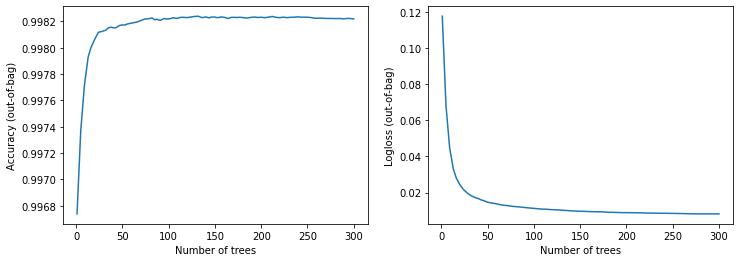

In [ ]:
#plot training history
import matplotlib.pyplot as plt

logs = model_1.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()